## In this jupyter notebook, we map KM values to all reactions in the training and the test set.
We either map values from the BRENDA database, if avaialable, or we predict KM values using our deep learning KM prediction tool

In [1]:
import pandas as pd
import os
from os.path import join
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
#from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")

## 1. Loading and preprocessing data

#### (a) Loading DataFrames

In [2]:
data_train = pd.read_pickle(join("..", "..", "data", "kcat_data", "splits", "train_df_kcat_ts.pkl"))
data_test = pd.read_pickle(join("..", "..", "data", "kcat_data", "splits", "test_df_kcat_ts.pkl"))

data_train["Uniprot ID"] = [UID[0] for UID in data_train["Uniprot IDs"]]
data_test["Uniprot ID"] = [UID[0] for UID in data_test["Uniprot IDs"]]

data_train.rename(columns = {"geomean_kcat" :"log10_kcat"}, inplace = True)
data_test.rename(columns = {"geomean_kcat" :"log10_kcat"}, inplace = True)

data = pd.concat([data_train, data_test], ignore_index=True)

Loading reaction DataFrame and creating ID lists for all substrates and products:

In [16]:
reaction_df = pd.read_pickle(join("..", "..", "data", "reaction_data", "all_reactions_with_IDs_and_FPs.pkl"))
reaction_df.head(2)

,substrate_InChI_set,product_InChI_set,Reaction ID,MW_frac,structural_fp,difference_fp,#substrates,#products
0,{InChI=1S/C17H21N4O9P/c1-7-3-9-10(4-8(7)2)21(1...,{InChI=1S/C17H23N4O9P/c1-7-3-9-10(4-8(7)2)21(1...,Reaction_0,1.0,1100110100001000000000110111010001000001111010...,"[0.0, 0.0, 0.0, 0.0, -10.0, 0.0, 0.0, 0.0, 0.0...",2,2
1,{InChI=1S/C17H23N4O9P/c1-7-3-9-10(4-8(7)2)21(1...,"{InChI=1S/H2O2/c1-2/h1-2H, InChI=1S/C17H21N4O9...",Reaction_1,1.0,1100010100000001010000110110000001000001111000...,"[0.0, 0.0, 0.0, 0.0, 10.0, 0.0, 0.0, 0.0, 0.0,...",2,2


#### (b) Creating DataFrame with all enzyme-substrate pairs for which we need a KM value:

In [18]:
df_KM = pd.DataFrame(columns = ["Sequence", "substrate ID", "reaction ID", "KM BRENDA", "KM predicted"])

for ind in data.index:
    reaction_ID = data["Reaction ID"][ind]
    seq = data["Sequence"][ind]
    if "_r" in str(reaction_ID):
        ID = reaction_ID.split("_r")[0]
        substrate_IDs = list(reaction_df.loc[reaction_df["Reaction ID"] == ID]["product_InChI_set"])[0]
    else:
        substrate_IDs = list(reaction_df.loc[reaction_df["Reaction ID"] == reaction_ID]["substrate_InChI_set"])[0]
    for sub_ID in list(substrate_IDs):
        df_KM = df_KM.append({"Sequence": seq, "substrate ID": sub_ID,
                              "reaction ID" : reaction_ID}, ignore_index=True)
    
df_KM

,Sequence,substrate ID,reaction ID,KM BRENDA,KM predicted
0,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,InChI=1S/C21H30N7O17P3/c22-17-12-19(25-7-24-17...,Reaction_127,NaN,NaN
1,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,"InChI=1S/C6H10O2/c1-3-4-6(8)5(2)7/h3-4H2,1-2H3",Reaction_127,NaN,NaN
2,MNYRYPPRYGPEWGSGGIYGLRFHNGTLYFTLAFEGEAHFITEDSH...,InChI=1S/H2O/h1H2,Reaction_796,NaN,NaN
3,MNYRYPPRYGPEWGSGGIYGLRFHNGTLYFTLAFEGEAHFITEDSH...,InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...,Reaction_796,NaN,NaN
4,MAVTAQAARRKERVLCLFDVDGTLTPARQKIDPEVAAFLQKLRSRV...,InChI=1S/C6H13O9P/c7-1-2-3(8)4(9)5(10)6(14-2)1...,Reaction_565,NaN,NaN
...,...,...,...,...,...
8979,MTERPRDCRPVVRRARTSDVPAIKQLVDTYAGKILLEKNLVTLYEA...,"InChI=1S/C5H10N2O3/c6-3(5(9)10)1-2-4(7)8/h3H,1...",Reaction_1253,NaN,NaN
8980,MTERPRDCRPVVRRARTSDVPAIKQLVDTYAGKILLEKNLVTLYEA...,InChI=1S/C23H38N7O17P3S/c1-12(31)51-7-6-25-14(...,Reaction_1253,NaN,NaN
8981,MAKMRAVDAAMYVLEKEGITTAFGVPGAAINPFYSAMRKHGGIRHI...,"InChI=1S/C2H2O3/c3-1-2(4)5/h1H,(H,4,5)",Reaction_1626,NaN,NaN
8982,MGAQLSTLGHMVLFPVWFLYSLLMKLFQRSTPAITLESPDIKYPLR...,InChI=1S/6CN.Fe/c6*1-2;/q;;;;;;-3,Reaction_898,NaN,NaN


#### (c) Calculating ECFPs for all substrates (for mapping to BRENDA data):

In [20]:
df_KM["ECFP"] = [AllChem.GetMorganFingerprintAsBitVect(Chem.inchi.MolFromInchi(Inchi), 3, nBits=1024).ToBitString()
                 for Inchi in df_KM["substrate ID"]]

## 2. Mapping BRENDA KM values to our data points:

We use a DataFrame with KM values from BRENDA from the following GitHub repository: https://github.com/AlexanderKroll/KM_prediction . If multiple KM values existed for the same enzyme-substrate pair, the geometric mean of the KM values was calculated.

In [23]:
brenda_KM = pd.read_pickle(join("..", "..", "data", "KM_data",
                           "brenda_df_checkpoint_4_KM_new.pkl"))

In [24]:
for ind in df_KM.index:
    ecfp = df_KM["ECFP"][ind]
    seq = df_KM["Sequence"][ind]
    help_df = brenda_KM.loc[brenda_KM["ECFP"] == ecfp].loc[brenda_KM["Sequence"] == seq]

    if len(help_df) > 0:
        df_KM["KM BRENDA"][ind] = np.log10(list(help_df["Km"])[0])

For how many enzmye-substrate pairs were we able to find a KM value from BRENDA?

In [25]:
len(df_KM.loc[~pd.isnull(df_KM["KM BRENDA"])])/len(df_KM)

0.07435440783615316

In [26]:
df_KM.to_pickle(join("..", "..", "data","KM_data", "df_KM.pkl"))

In [4]:
df_KM = pd.read_pickle(join("..", "..", "data","KM_data", "df_KM.pkl"))
df_KM.head(2)

,Sequence,substrate ID,reaction ID,KM BRENDA,KM predicted,ECFP
0,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,InChI=1S/C21H30N7O17P3/c22-17-12-19(25-7-24-17...,Reaction_127,NaN,NaN,0000000001000000100000000000100000000000000000...
1,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,"InChI=1S/C6H10O2/c1-3-4-6(8)5(2)7/h3-4H2,1-2H3",Reaction_127,NaN,NaN,0000000000000000000000000000000001000000000000...


## 3. Predicting KM values using a machine learning model

We used the function implemented in the GitHub repository "https://github.com/AlexanderKroll/KM_prediction_function" to make predictions for missing KM values. Here, we load the resulting DataFrame:

In [6]:
df_KM = pd.read_pickle(join("..", "..", "data","KM_data", "df_KM_with_predictions.pkl"))

In [8]:
import matplotlib.pyplot as plt

In [11]:
df_KM

,Sequence,substrate ID,reaction ID,KM BRENDA,KM predicted,ECFP,prediction method,KM [mM] (predicted)
0,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,InChI=1S/C21H30N7O17P3/c22-17-12-19(25-7-24-17...,Reaction_127,NaN,NaN,0000000001000000100000000000100000000000000000...,enzyme and substrate information,0.010457
1,MELFLAGRRVLVTGAGKGIGRGTVQALHATGARVVAVSRTQADLDS...,"InChI=1S/C6H10O2/c1-3-4-6(8)5(2)7/h3-4H2,1-2H3",Reaction_127,NaN,NaN,0000000000000000000000000000000001000000000000...,enzyme and substrate information,0.227367
2,MNYRYPPRYGPEWGSGGIYGLRFHNGTLYFTLAFEGEAHFITEDSH...,InChI=1S/H2O/h1H2,Reaction_796,NaN,NaN,0000000000000000000000000000000000000000000000...,enzyme and substrate information,1.640480
3,MNYRYPPRYGPEWGSGGIYGLRFHNGTLYFTLAFEGEAHFITEDSH...,InChI=1S/C12H15NO8/c14-5-8-9(15)10(16)11(17)12...,Reaction_796,NaN,NaN,0000000000000100000000000000000000000011000000...,enzyme and substrate information,0.067011
4,MAVTAQAARRKERVLCLFDVDGTLTPARQKIDPEVAAFLQKLRSRV...,InChI=1S/C6H13O9P/c7-1-2-3(8)4(9)5(10)6(14-2)1...,Reaction_565,-1.267606,NaN,0000000000000100000000000000000000000000000000...,enzyme and substrate information,0.192417
...,...,...,...,...,...,...,...,...
8979,MTERPRDCRPVVRRARTSDVPAIKQLVDTYAGKILLEKNLVTLYEA...,"InChI=1S/C5H10N2O3/c6-3(5(9)10)1-2-4(7)8/h3H,1...",Reaction_1253,NaN,NaN,0100000000000000000000000000000000000000000000...,enzyme and substrate information,0.605696
8980,MTERPRDCRPVVRRARTSDVPAIKQLVDTYAGKILLEKNLVTLYEA...,InChI=1S/C23H38N7O17P3S/c1-12(31)51-7-6-25-14(...,Reaction_1253,NaN,NaN,1100100001000000000100000000000001000000000000...,enzyme and substrate information,0.032394
8981,MAKMRAVDAAMYVLEKEGITTAFGVPGAAINPFYSAMRKHGGIRHI...,"InChI=1S/C2H2O3/c3-1-2(4)5/h1H,(H,4,5)",Reaction_1626,-0.045757,NaN,0000000000000000000000000000000000000000000000...,enzyme and substrate information,1.722921
8982,MGAQLSTLGHMVLFPVWFLYSLLMKLFQRSTPAITLESPDIKYPLR...,InChI=1S/6CN.Fe/c6*1-2;/q;;;;;;-3,Reaction_898,NaN,NaN,0000000000000100000000000000000000000000000000...,enzyme and substrate information,0.553386


In [14]:
df_KM["KM [mM] (predicted)"] = np.log10(df_KM["KM [mM] (predicted)"])

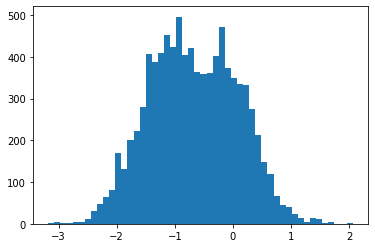

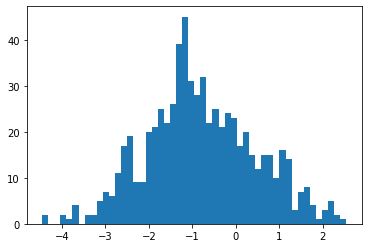

In [15]:
plt.hist(df_KM["KM [mM] (predicted)"] , bins = 50)
plt.show()

plt.hist(df_KM["KM BRENDA"], bins = 50)
plt.show()

### 4. Mapping KM values to training and test set:

To calculate a KM value for a whole reaction, we take the geometric mean of the KM values if multiple substrates exist. If a value from BRENDA and a predicted KM value exist for an enzyme-substrate pair, we give preference to the value from BRENDA.

In [27]:
data_train["KM values"] = ""

for ind in data_train.index:
    seq, r_ID = data_train["Sequence"][ind], data_train["Reaction ID"][ind] 
    help_df = df_KM.loc[df_KM["Sequence"] == seq].loc[df_KM["reaction ID"] == r_ID]
    KM_values = []
    
    for ind2 in help_df.index:
        if not pd.isnull(help_df["KM BRENDA"][ind2]):
            KM_values.append(help_df["KM BRENDA"][ind2])
        else:
            KM_values.append(help_df["KM [mM] (predicted)"][ind2])
            
    data_train["KM values"][ind] = KM_values

In [28]:
data_test["KM values"] = ""

for ind in data_test.index:
    seq, r_ID = data_test["Sequence"][ind], data_test["Reaction ID"][ind] 
    help_df = df_KM.loc[df_KM["Sequence"] == seq].loc[df_KM["reaction ID"] == r_ID]
    KM_values = []
    
    for ind2 in help_df.index:
        if not pd.isnull(help_df["KM BRENDA"][ind2]):
            KM_values.append(help_df["KM BRENDA"][ind2])
        else:
            KM_values.append(help_df["KM [mM] (predicted)"][ind2])
            
    data_test["KM values"][ind] = KM_values

In [29]:
data_train.to_pickle(join("..", "..", "data", "kcat_data", "splits", "train_df_kcat_with_KM.pkl"))
data_test.to_pickle(join("..", "..", "data", "kcat_data", "splits", "test_df_kcat_with_KM.pkl"))